In [44]:
import scanpy as sc
import anndata as ad
import squidpy as sq

import numpy as np
import pandas as pd

import sklearn

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.2.0
PyQt5                       NA
asciitree                   NA
asttokens                   NA
backcall                    0.2.0
brotli                      NA
cffi                        1.15.0
click                       8.1.3
cloudpickle                 2.1.0
colorama                    0.4.4
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.12.0
dask                        2022.8.0
dask_image                  2021.12.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
defusedxml                  0.7.1
distributed                 2022.8.0
docrep                      0.3.2
entrypoints                 0.4
executing                   0.8.3
fasteners                   0.17.3
fsspec                      2022.7.1
h5py                        3.6.0
heapdict                    NA
igraph                      0.9.11
im

I use the mouse brain data set used in [this squidpy tutorial](https://squidpy.readthedocs.io/en/stable/auto_tutorials/tutorial_visium_hne.html#sphx-glr-auto-tutorials-tutorial-visium-hne-py).

I combine this with the [scanpy tutorial for visium data](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html)

In [3]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()

# Do that using it from a ramdisk for better processing
# Load on ramdisk with:
# 1. mount ramdisk
# 2. sudo cp Vic/development/data/Mouse_Brain_squidpy_tutorial.h5ad /mnt/ramdisk/
# 3. sudo cp Vic/development/data/V1_Adult_Mouse_Brain_image.tif /mnt/ramdisk

# img = sq.im.ImageContainer.load("/mnt/ramdisk/V1_Adult_Mouse_Brain_image.tif")
# adata = sc.read_h5ad("/mnt/ramdisk/Mouse_Brain_squidpy_tutorial.h5ad")

Adding image layer `image`


In [4]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

# normalize expression data
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [5]:
# skipping the QC and preprocessing step bc. I think this stuff should be filtered/preprocessed already

## Image features
Here, we will extract summary features at different crop sizes and scales to allow the calculation of multi-scale features and segmentation features.  (squidpy)

In [6]:
# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table
adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)

Calculating features `['summary']` using `4` core(s)


  0%|          | 0/2688 [00:00<?, ?/s]

Adding `adata.obsm['features_summary_scale1.0']`
Finish (0:00:07)
Calculating features `['summary']` using `4` core(s)


  0%|          | 0/2688 [00:00<?, ?/s]

Adding `adata.obsm['features_summary_scale2.0']`
Finish (0:00:20)


We can use the extracted image features to compute a new cluster annotation. This could be useful to gain insights in similarities across spots based on image morphology.

computing PCA
    with n_comps=10
    finished (0:00:00)
computing neighbors
    using data matrix X directly


/tmp/ipykernel_13235/636492175.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(features)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
running Leiden clustering
    finished: found 19 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


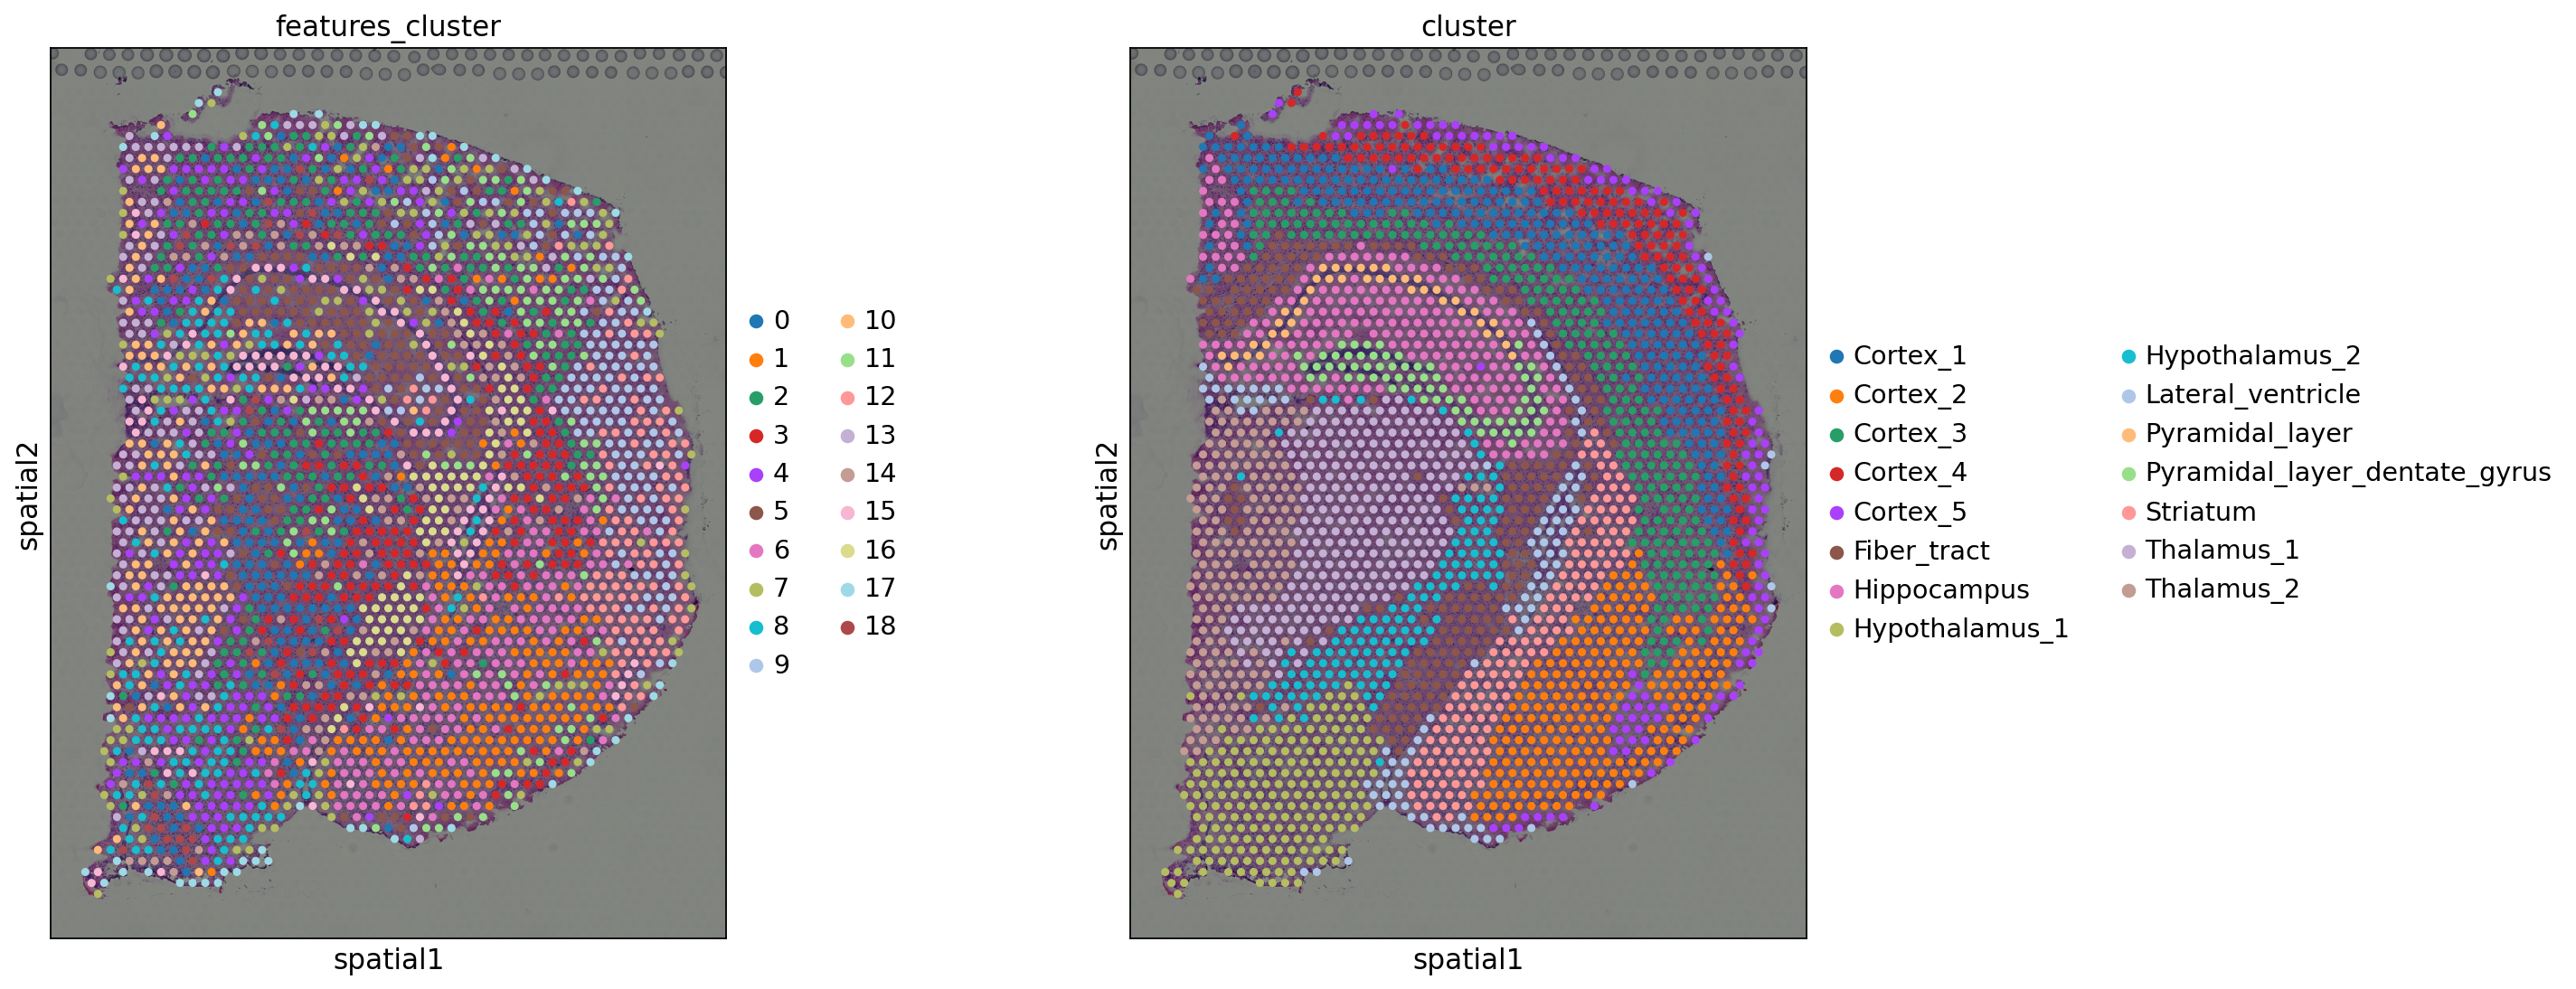

In [7]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "cluster"])

## Extract locations.txt and dge.txt from the anndata object

In [8]:
coord = adata.obsm['spatial']

In [29]:
coord_df = pd.DataFrame(data=coord, columns=['xcoord','ycoord'])\
# coord_df.to_csv('data/10x_MouseBrain_coordinates.csv', index=False)

In [43]:
coord_df[:4]

,xcoord,ycoord
0,8230,7237
1,4170,1611
2,2519,8315
3,7679,2927


In [ ]:
# adata.T.to_df().to_csv('data/10x_MouseBrain_dge.csv') # that's the whole sc data that we need for reconstruction

In [ ]:
# ToDo for getting the marker genes ~100 - get highly-variable genes and take the top 100 or smth

In [11]:
high_var_index = adata.var[adata.var['highly_variable'] == True].index
print(high_var_index[:2])

Index(['Sox17', '4732440D04Rik'], dtype='object')


In [12]:
atlas_genes_indexes = []
for gene in high_var_index[:10]:
    atlas_genes_indexes.append(adata.var_names.get_loc(gene))
atlas_genes_indexes

[1, 10, 11, 16, 17, 21, 30, 32, 38, 44]

In [13]:
data_to_write = pd.DataFrame(adata.X[:,atlas_genes_indexes].toarray(),columns=high_var_index[:10])
# data_to_write.to_csv("data/tmp.txt", index_label=False)

In [ ]:
adata[:,gene].X

# Check randomnes/uniqueness of the marker gene locations

In order to have a good atlas, the marker genes should not all be cluttered in one or few locations but should actually span the whole map - ideally.

There are two ideas so far:

* Nikos: sth simple like counting gene combos per spot should work e.g. spot1:gene1_gene3_gene4, spot2:gene1_gene2, spot3:gene4 etc, all three spots are unique here
Comment me: although then I still don't know how distributed the spots are, no?
* I think I would like to try some kind of randomness test on how much the points aka locaiton cooridantes are distributed accross the space - and maybe additionally how much of the space they cover. Maybe getting some kind of ratio value from this and using this as orientation
* Some reading on the randomness stuff is [here](https://www.geeksforgeeks.org/runs-test-of-randomness-in-python/#:~:text=Runs%20test%20of%20randomness%20is,increasing%20values%20or%20decreasing%20values.)
* also wikipedia, also ask Jakob :)

Update:
I talked to Jakob and the idea of:
1. transform the location matrix into a heap
2. collect the differences from any point to a marker-gene point
3. calculate the deviation of the means
4. aim for a set that has the lowest deviation possible

New approach:
using KD-trees - see [wiki](https://en.wikipedia.org/wiki/K-d_tree), [sklear](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KDTree.html)

Last edit:
I realized that this simple approach of Nikos together with a sanity check of the location coverage is all I need. So I wrote it (see below).
ToDo: make a function out of this that one could use as an extra sanity check of atlas quality

## Lazy method - even distribution by coverage - uniqueness by like nikos gene combos ?

In [206]:
savepath = "data/mouse_brain_test_atlas.txt"

# all highly variable genes from which I will subsample
high_var_index = adata.var[adata.var['highly_variable'] == True].index

# subsampling
marker_subsample_names = high_var_index.to_frame().sample(100)
# marker_subsample_names = adata.var_names.to_frame().sample(50)
marker_subsample_idx = []
for gene in marker_subsample_names[0] :
    marker_subsample_idx.append(adata.var_names.get_loc(gene))
marker_subsample = pd.DataFrame(adata.X[:, marker_subsample_idx].toarray(),
                                columns=marker_subsample_names[0])

# count sets
loc_w_gene = 0
loc_wo_gene = 0
for idx,row in marker_subsample.iterrows():
    if (row == 0).all():
        loc_wo_gene += 1
    else:
        loc_w_gene += 1
marker_cov = loc_w_gene/marker_subsample.shape[0]
print('num loc w gene = {} \n'
      'num loc w/o gene = {}\n'
      'therefore gene marker cov = {}'.format(loc_w_gene, loc_wo_gene, marker_cov))

# evaluate point uniqueness
# 1. binarize marker_subsample
marker_subsample_bin = marker_subsample.mask(marker_subsample > 0, 1 )
# 2. vector of gene sets
gene_sets_p_loc = []
# 3. get gene set per location
for idx, row in marker_subsample_bin.iterrows():
    gene_sets_p_loc.append(
        tuple(row.index[row.loc[:] == 1])
    )
# 4. count how many unique sets are in the list
num_unique = len(set(gene_sets_p_loc))

# 5. calculate ratio of covered locations that are unique
unique_cov = num_unique/(marker_subsample.shape[0] - loc_wo_gene)
print("%.1f %% of the marker-locations are unique." % unique_cov)

# 6. write atlas to file
if marker_cov == 1.0 and unique_cov == 1.0:
    marker_subsample.to_csv(savepath, index_label=False)
else:
    print("you should resample before saving this")

num loc w gene = 2688 
num loc w/o gene = 0
therefore gene marker cov = 1.0
1.0 % of the marker-locations are unique.


In [113]:
atlas_genes_indexes = []
for gene in high_var_index[:10]:
    atlas_genes_indexes.append(adata.var_names.get_loc(gene))
atlas_genes_indexes

[1, 10, 11, 16, 17, 21, 30, 32, 38, 44]

In [119]:
data_to_write = pd.DataFrame(adata.X[:,atlas_genes_indexes].toarray(),columns=high_var_index[:10])
data_to_write.to_csv("data/tmp.txt", index_label=False)

In [102]:
adata[:,gene].X

<2688x1 sparse matrix of type '<class 'numpy.float32'>'
	with 298 stored elements in Compressed Sparse Row format>

# Check randomnes/uniqueness of the marker gene locations

In order to have a good atlas, the marker genes should not all be cluttered in one or few locations but should actually span the whole map - ideally.

There are two ideas so far:

* Nikos: sth simple like counting gene combos per spot should work e.g. spot1:gene1_gene3_gene4, spot2:gene1_gene2, spot3:gene4 etc, all three spots are unique here
Comment me: although then I still don't know how distributed the spots are, no?
* I think I would like to try some kind of randomness test on how much the points aka locaiton cooridantes are distributed accross the space - and maybe additionally how much of the space they cover. Maybe getting some kind of ratio value from this and using this as orientation
* Some reading on the randomness stuff is [here](https://www.geeksforgeeks.org/runs-test-of-randomness-in-python/#:~:text=Runs%20test%20of%20randomness%20is,increasing%20values%20or%20decreasing%20values.)
* also wikipedia, also ask Jakob :)